In [25]:
import pandas, matplotlib.pyplot as plt, geopandas

# NVDI
Inlezen tabel NVDI per perceel, en hieruit alle percelen selecteren met grasland.

In [26]:
df = pandas.read_csv(r'.\data\ndvi_stats_percelen.csv', sep=';', parse_dates=['date_num'])
df_gras = df.loc[df['gewasgroep']=='Grasland']

Bepalen gemiddelde NVDI en aantal datapunten per gemiddelde. Vervolgens wordt de NVDI berekend voor alle datapunten in maart t/m mei

In [27]:
nvdi_mean = df_gras.loc[:,'MEAN'].groupby(df_gras['date_num']).mean()
nvdi_count = df_gras.loc[:,'MEAN'].groupby(df_gras['date_num']).count()

nvdi_mean_voorjaar = nvdi_mean.loc[(nvdi_mean.index.month>=3) & (nvdi_mean.index.month>=5)].mean()

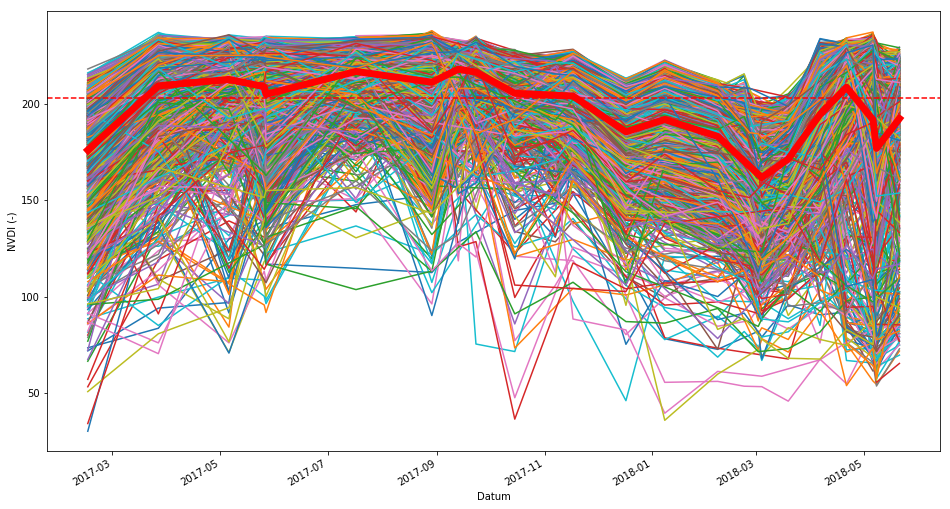

In [28]:
fig, ax = plt.subplots(figsize=[16,9])
for i in df_gras['OBJECTID'].unique():
    y = df_gras.loc[df['OBJECTID']==i]['MEAN']
    x = df_gras.loc[df['OBJECTID']==i]['date_num']
    ax.plot(x, y)
nvdi_mean.loc[nvdi_count>1500].plot(ax=ax, style='r-', linewidth=7.0)
ax.axhline(nvdi_mean_voorjaar, linestyle='--', c='r')
ax.set_ylabel('NVDI (-)')
ax.set_xlabel('Datum');

De maximale NVDI per perceel in de maanden tussen maart en mei en het verschil met het gemiddelde 

In [29]:
df_gras_max_voorjaar = df_gras.loc[(df_gras['month']<=5) & (df_gras['month']>=3), ['MEAN']].groupby(df_gras['OBJECTID']).max()
df_gras_max_voorjaar.columns = ['Max']
df_gras_max_voorjaar['dif'] = df_gras_max_voorjaar['Max']-nvdi_mean_voorjaar
df_gras_max_voorjaar.index.names = ['idx']
df_gras_max_voorjaar['OBJECTID']=df_gras_max_voorjaar.index

Bepalen 25% laagste percelen

In [30]:
nvdi_tresh = df_gras_max_voorjaar['Max'].quantile(0.25)
df_gras_max_voorjaar['tresh'] = (df_gras_max_voorjaar['Max']<=nvdi_tresh).astype(int)

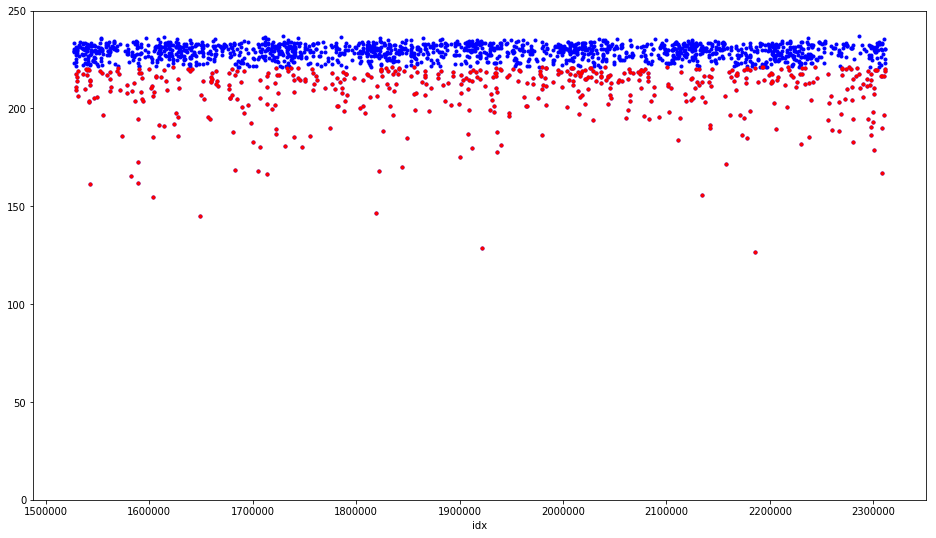

In [31]:
df_gras_max_voorjaar['Max'].plot(figsize=[16,9], style='b.')
df_gras_max_voorjaar.loc[df_gras_max_voorjaar['Max']<nvdi_tresh, 'Max'].plot(figsize=[16,9], style='r.')
plt.ylim(0,250);

# AHN

In [32]:
df_ahn = pandas.read_csv(r'data\AHN2_5m.csv')

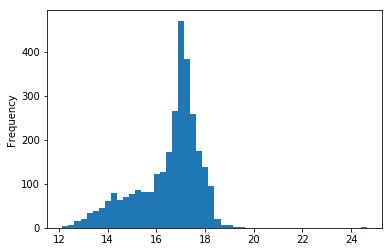

In [33]:
df_ahn['AHN_MEAN'].plot.hist(50)

# Organisch stof

In [166]:
df_os=pandas.read_csv('data\OS_Marke.csv', sep=';')
df_os.index = df_os['OBJECTID']
df_os.index.rename = ['idx']
df_os['mean_os']=df_os.drop(['MarkeID','OBJECTID'], axis=1).mean(axis=1)
df_os = df_os.rename(columns={'2015': 'OS_latest'})

In [169]:
df_os_rene = pandas.read_csv(r'data\HobelmanOS.csv', ';', index_col='objectid')
df_os_rene=df_os_rene.rename(columns={'04-okt-17':'OS_latest'})

In [173]:
df_os_tot = pandas.concat([df_os[['OS_latest']], df_os_rene[['OS_latest']]])
df_os_tot['OBJECTID'] = df_os_tot.index

# Bos

In [223]:
import geopandas
gdf_bos = geopandas.read_file(r'data\spatial_join_bos.shp')
#gdf_bos = gdf_bos.rename(columns={'OBJECTID':'ID'})
#gdf_bos = gdf_bos.rename(columns={'OBJECTID_1':'OBJECTID'})

# Grondwaterstand

In [175]:
df_gvg=pandas.read_excel(r'data\glg_gvg3_mv.xlsx')

In [176]:
df_gvg=df_gvg.rename(columns={'MEAN': 'MEAN_gvg'})

# Koppelen data aan shape

In [225]:
import geopandas

gdf = geopandas.read_file(r'.\data\gewaspercelen_2017_regio.shp')
gdf = gdf.merge(df_gras_max_voorjaar[['OBJECTID','Max', 'dif', 'tresh']], on='OBJECTID')
gdf = gdf.merge(df_ahn[['OBJECTID', 'AHN_MEAN']], on='OBJECTID')
gdf = gdf.merge(df_gvg[['OBJECTID', 'MEAN_gvg']], on='OBJECTID')
gdf = gdf.merge(df_os_tot[['OS_latest','OBJECTID']], on='OBJECTID')
gdf = gdf.merge(gdf_bos[['OBJECTID', 'Join_Count']], on='OBJECTID')
gdf.to_file('results\precelen_nvdi.shp')

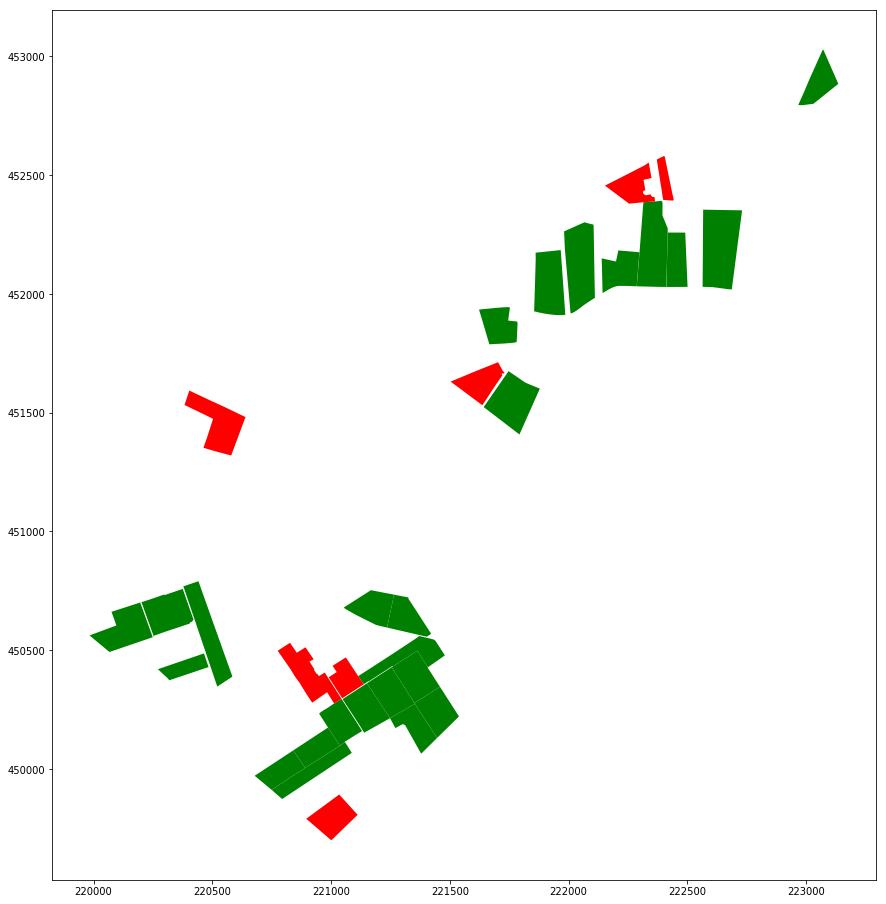

In [260]:
ax = gdf.loc[gdf['tresh']==0].plot(color='g', figsize=[16, 16])
ax = gdf.loc[gdf['tresh']==1].plot(color='r', figsize=[16, 16], ax=ax)

plt.savefig('percelen.png')

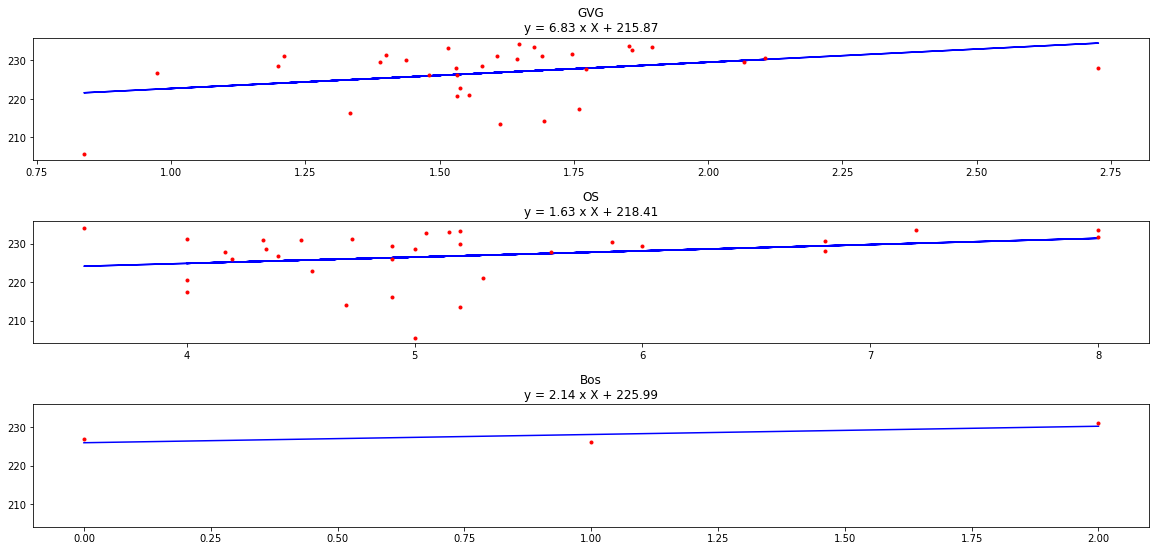

In [262]:
import numpy

fig, ax = plt.subplots(3, figsize=[20,9], sharey=True)
#x,y=gdf['AHN_MEAN'], gdf['Max']
#m,b = numpy.polyfit(x, y, 1) 
#ax[0].plot(x, m*x+b, 'b-') 
#ax[0].plot(x,y,'r.')
#ax[0].set_title('AHN\ny = {} x X + {}'.format(round(m,2),round(b,2)));


x,y=gdf['MEAN_gvg'], gdf['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[0].plot(x, m*x+b, 'b-') 
ax[0].plot(x,y, 'r.')
ax[0].set_title('GVG\ny = {} x X + {}'.format(round(m,2),round(b,2)));

x,y=gdf['OS_latest'], gdf['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[1].plot(x, m*x+b, 'b-') 
ax[1].plot(x,y,'r.')
ax[1].set_title('OS\ny = {} x X + {}'.format(round(m,2),round(b,2)));

bos = gdf[['Join_Count', 'Max']].groupby(gdf['Join_Count']).mean()
x,y=bos['Join_Count'], bos['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[2].plot(x, m*x+b, 'b-') 
ax[2].plot(x,y,'r.')
ax[2].set_title('Bos\ny = {} x X + {}'.format(round(m,2),round(b,2)));

plt.subplots_adjust(hspace = 0.5)
plt.savefig('verbanden.png')

In [247]:
df_slecht = gdf.loc[gdf['tresh']==1, ['AHN_MEAN', 'MEAN_gvg', 'OS_latest', 'Max', 'Join_Count']]

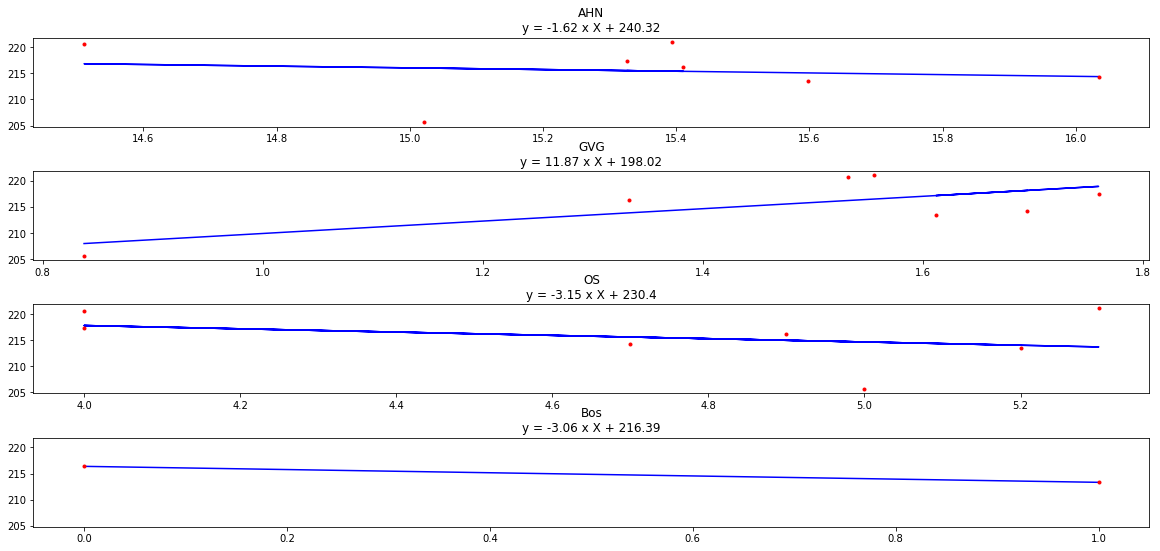

In [257]:
fig, ax = plt.subplots(4, figsize=[20,9], sharey=True)
x,y=df_slecht['AHN_MEAN'], df_slecht['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[0].plot(x, m*x+b, 'b-') 
ax[0].plot(x,y,'r.')
ax[0].set_title('AHN\ny = {} x X + {}'.format(round(m,2),round(b,2)));

x,y=df_slecht['MEAN_gvg'], df_slecht['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[1].plot(x, m*x+b, 'b-') 
ax[1].plot(x,y, 'r.')
ax[1].set_title('GVG\ny = {} x X + {}'.format(round(m,2),round(b,2)));

x,y=df_slecht['OS_latest'], df_slecht['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[2].plot(x, m*x+b, 'b-') 
ax[2].plot(x,y,'r.')
ax[2].set_title('OS')
ax[2].set_title('OS\ny = {} x X + {}'.format(round(m,2),round(b,2)));

bos = df_slecht[['Join_Count', 'Max']].groupby(gdf['Join_Count']).mean()
x,y=bos['Join_Count'], bos['Max']
m,b = numpy.polyfit(x, y, 1) 
ax[3].plot(x, m*x+b, 'b-') 
ax[3].plot(x,y,'r.')
ax[3].set_title('Bos\ny = {} x X + {}'.format(round(m,2),round(b,2)))

plt.subplots_adjust(hspace = 0.5)

In [273]:
import geopandas

gdf2 = geopandas.read_file(r'.\data\gewaspercelen_2017_regio.shp')
gdf2 = gdf2.merge(df_gras_max_voorjaar[['OBJECTID','Max', 'dif', 'tresh']], on='OBJECTID')
gdf2 = gdf2.merge(df_ahn[['OBJECTID', 'AHN_MEAN']], on='OBJECTID')
gdf2 = gdf2.merge(df_gvg[['OBJECTID', 'MEAN_gvg']], on='OBJECTID')
gdf2 = gdf2.merge(gdf_bos[['OBJECTID', 'Join_Count']], on='OBJECTID')
gdf2 = gdf2.loc[gdf2['tresh']==1]

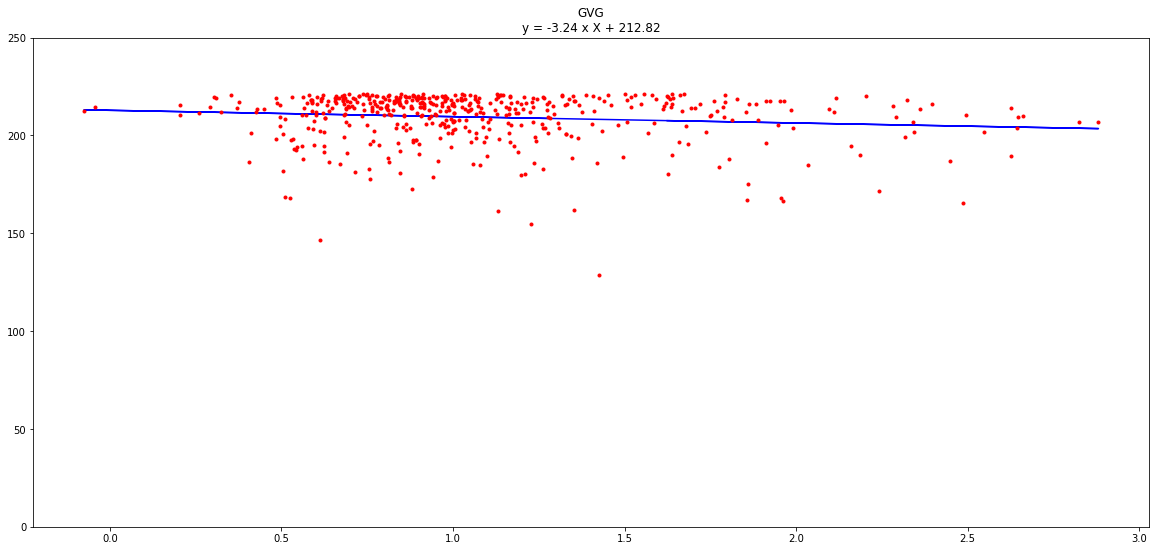

In [275]:
fig, ax = plt.subplots(figsize=[20,9], sharey=True)
x,y=gdf2['MEAN_gvg'], gdf2['Max']
m,b = numpy.polyfit(x, y, 1) 
ax.plot(x, m*x+b, 'b-') 
ax.plot(x,y, 'r.')
ax.set_title('GVG\ny = {} x X + {}'.format(round(m,2),round(b,2)))
ax.set_ylim(0, 250);

In [272]:
gdf2.loc[gdf2['tresh']==1]

,OBJECTID,CAT_GEWASC,GWS_GEWASC,GEOMETRIE_,GEOMETRIE1,GWS_GEWAS,selected,geometry,Max,dif,tresh,AHN_MEAN,MEAN_gvg,Join_Count
7,1528999,Grasland,265,280.848034,4641.119808,"Grasland, blijvend",0,"POLYGON ((222153.4899999984 450844.5289999992,...",209.357143,6.279463,1,15.909989,1.277900,1
8,1529027,Grasland,265,317.968357,3978.058168,"Grasland, blijvend",0,"POLYGON ((229753.1030000001 454050.2049999982,...",217.605263,14.527583,1,16.939471,0.841361,0
11,1529296,Grasland,266,579.601954,11320.034999,"Grasland, tijdelijk",0,"POLYGON ((227965.2863750011 448534.4384999983,...",210.765217,7.687537,1,17.450645,0.684008,0
19,1529778,Grasland,266,436.631893,7563.082461,"Grasland, tijdelijk",0,"POLYGON ((228146.9600000009 449866.3729999997,...",214.240000,11.162320,1,17.207440,0.712350,0
21,1530105,Grasland,336,386.009901,6656.657965,"Grasland, natuurlijk. Areaal met een natuurbeh...",0,"POLYGON ((226953.0300000012 451962.8220000006,...",216.164179,13.086499,1,16.940910,0.914670,1
22,1531017,Grasland,265,193.414405,1809.633963,"Grasland, blijvend",0,"POLYGON ((226747.3680000007 453588.2749999985,...",206.235294,3.157614,1,17.036840,1.304687,0
23,1531018,Grasland,265,285.373315,4967.865755,"Grasland, blijvend",0,"POLYGON ((226818.7934999987 453430.875, 226877...",219.020408,15.942728,1,17.020779,1.265635,1
35,1536240,Grasland,265,362.245142,7213.627381,"Grasland, blijvend",0,"POLYGON ((220324.1079999991 450167.3720000014,...",217.527778,14.450097,1,14.888186,1.356825,1
41,1537650,Grasland,265,384.824058,4694.508499,"Grasland, blijvend",0,"POLYGON ((227459.4860000014 454208.0390000008,...",209.928571,6.850891,1,17.619529,1.749414,1
45,1538691,Grasland,265,299.550786,5536.742503,"Grasland, blijvend",0,"POLYGON ((227824.4079999998 447519.9140000008,...",219.927273,16.849592,1,18.012288,0.809831,0
